In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Load data into pandas dataframe, and take a look. 
games_df = pd.read_csv('2021-03new.csv')
print(games_df.iloc[1])

PGN            1. c4 Ng6 2. b3 O-O 3. Ng3 c5 4. O-O d5 5. cxd...
Event                                        Rated Chess960 game
Result                                                       0-1
BlackElo                                                    2482
WhiteElo                                                    2376
FEN            nbbqrkrn/pppppppp/8/8/8/8/PPPPPPPP/NBBQRKRN w ...
Termination                                               Normal
TimeControl                                                 30+0
UTCTime                                                 00:00:14
Name: 1, dtype: object


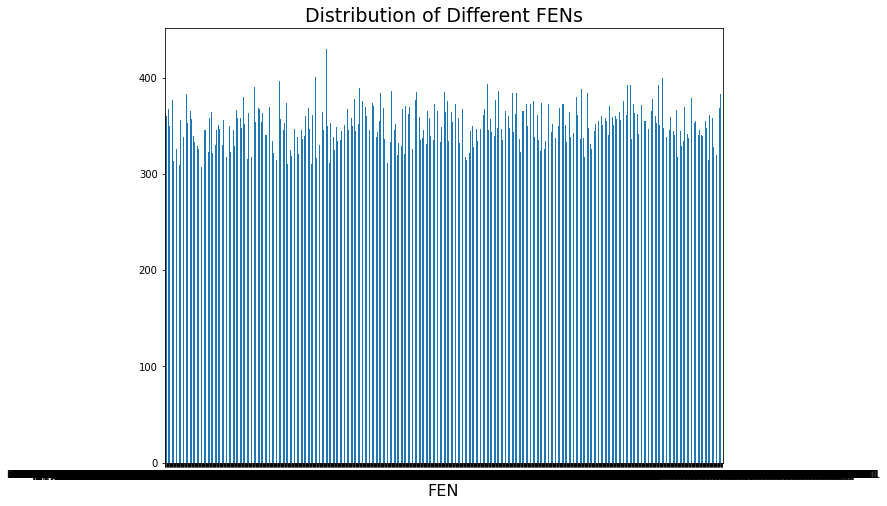

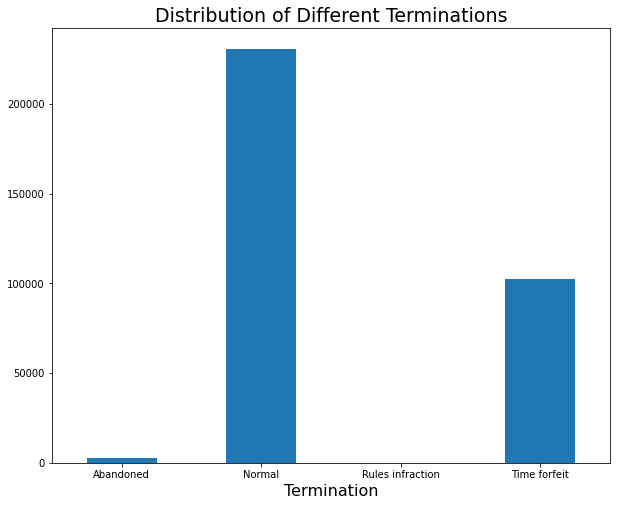

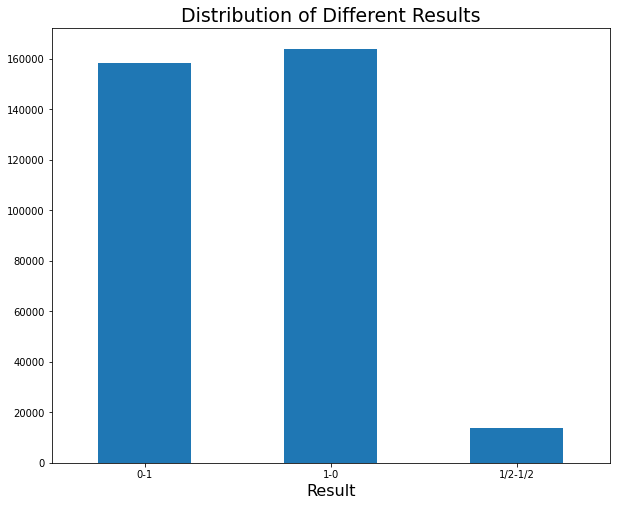

In [7]:
# Lets also look at some distributions 

def general_dist(label, print_now=False):
    dist_list = games_df.groupby(label).count().iloc[:, 1] 
    if print_now:
        print(dist_list)
        
    plt.figure(figsize=(10, 8))
    dist_list.plot.bar(rot=0)
    plt.xlabel(label, fontsize=16)
    plt.title("Distribution of Different %ss" % label, fontsize=19)
    plt.show()
    
general_dist('FEN')
general_dist('Termination')
#general_dist('TimeControl')
general_dist('Result')


In [111]:
# Creating a heatmap visualizing the move tendencies requires us to, for every move in every game, count its' occurence. 

# Ignoring castling rights altogether. 

import re

def prob_per_piece(games): 
    prob_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    char_blacklist = ['O', '-', '.']
    
    # Creates a dictionary containing a board [a-h][1-8] for every peice in pieces. 
    for p in pieces:
        chess_dict = {}
        for horizontal in pawn:
            for vertical in range(1, 9):
                chess_dict[horizontal+str(vertical)] = 0
        prob_dict[p] = chess_dict
        
    #print(prob_dict)
    for game in games['PGN']:
        moves = []
        current_move = ""
        for char in game:
                if char == ' ':
                    moves.append(current_move)
                    current_move = ""
                else:
                    current_move = current_move + char
                    continue
        def filter_fun(variable):
            pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
            pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
            # conditional = ['\\', 'r']
            if (bool(re.match('^(?=.*[0-9])(?=.*[a-zA-Z]$)', variable))) | (bool(re.search(r'(?<![^\s>])([0-9]+)\.', variable))):
                return False
            else:
                return True
        filtered_moves = filter(filter_fun ,moves)
        for move in filtered_moves: 
            if move[0] in pieces: #find combination of coloumn and number
                res = re.findall(r'[a-h]{1}[1-8]', move)
                prob_dict[move[0]][res[0]] += 1
            elif (move[0] in char_blacklist):
                continue
            else: 
                res = re.findall(r'[a-h]{1}[1-9]{1}', move)
                prob_dict['P'][res[0]] += 1
                
    return prob_dict

prob_dict = prob_per_piece(games_df)

#([BKNPQR][ld][a-h][1-8])|((?:(?:[a-h][1-8]\s*){2})+)
# pat = re.compile(r'^((?!--).)*$')
# [i for i in List1 if pat.match(i)]
# ( (bool(re.search(r'(?<![^\s>])([0-9]+)\.', variable))) & (not (bool(re.search(r'\\', variable)))) )

In [109]:
# This function is from "Visualizing Chess Game Length and Piece Movement♟️" on kaggle from Evan Zhang! 
# Link: https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement
def visualize_piece_prob(prob_list, visualize_list_raw=['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King'], vis_percentage=True, seaborn=True):
    """
    Driver function for visualizing the probability that each chess piece lands on a certain square
    Utilizes seaborn heatmap, if set to false, will use matplotlib heatmap
    """
    P_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    for p in pieces:
        chess_dict = {}
        for horizontal in pawn:
            for vertical in range(1, 9):
                chess_dict[horizontal+str(vertical)] = 0
        P_dict[p] = chess_dict

    for prob_dict in prob_list:
        for piece in prob_dict:
            for key in prob_dict[piece]: # here
                P_dict[piece][key] += prob_dict[piece][key]
    
    visualize_list = []
    for label in visualize_list_raw:
        if label == 'Knight':
            visualize_list.append('N')
        else:
            visualize_list.append(label[0])
    
    if seaborn:
        fig, ax = plt.subplots(len(visualize_list), figsize=(12, len(visualize_list)*8))
        r = 0
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(val_list[i+8*j]/summ)
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)

            heatmap = sns.heatmap(plot_list, cmap='YlOrRd', annot=True, fmt=".3%" if vis_percentage else "d", ax=ax[r], 
                                  cbar_kws={'label': 'Proportion (out of 1)' if vis_percentage else 'Raw Count'})
            ax[r].set_title("%s of %s Moving to Square on Chessboard" % ('Probability' if vis_percentage else 'Raw Count', visualize_list_raw[r]), fontsize=16)
            ax[r].set_xticklabels(pawn, fontsize=14)
            ax[r].set_yticklabels(np.arange(8, 0, -1), fontsize=14)
            r += 1

        fig.tight_layout()
        plt.subplots_adjust(hspace=0.2)
        plt.show()
    else:    
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(round(val_list[i+8*j]/summ*100, 3))
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)

            plt.figure(figsize=(12, 8))
            plt.imshow(plot_list, cmap='YlOrRd', interpolation='nearest')
            cbar = plt.colorbar()
            if vis_percentage:
                cbar.set_label("Probability (Percentage)", rotation=270, fontsize=16, labelpad=20)
            else:
                cbar.set_label("Raw Count", rotation=270, fontsize=16, labelpad=20)
            for i in range(8):
                for j in range(8):
                    tmp_str = str(plot_list[i][j])
                    if vis_percentage:
                        tmp_str += "%"

                    plt.text(j, i, tmp_str, ha="center", va="center", color="black")

            plt.title("%s of %s Moving to Square on Chessboard" % ('Probability' if vis_percentage else 'Raw Count', piece), fontsize=16)
            plt.xticks(np.arange(0, 8), pawn, fontsize=14)
            plt.yticks(np.arange(0, 8), np.arange(8, 0, -1), fontsize=14)

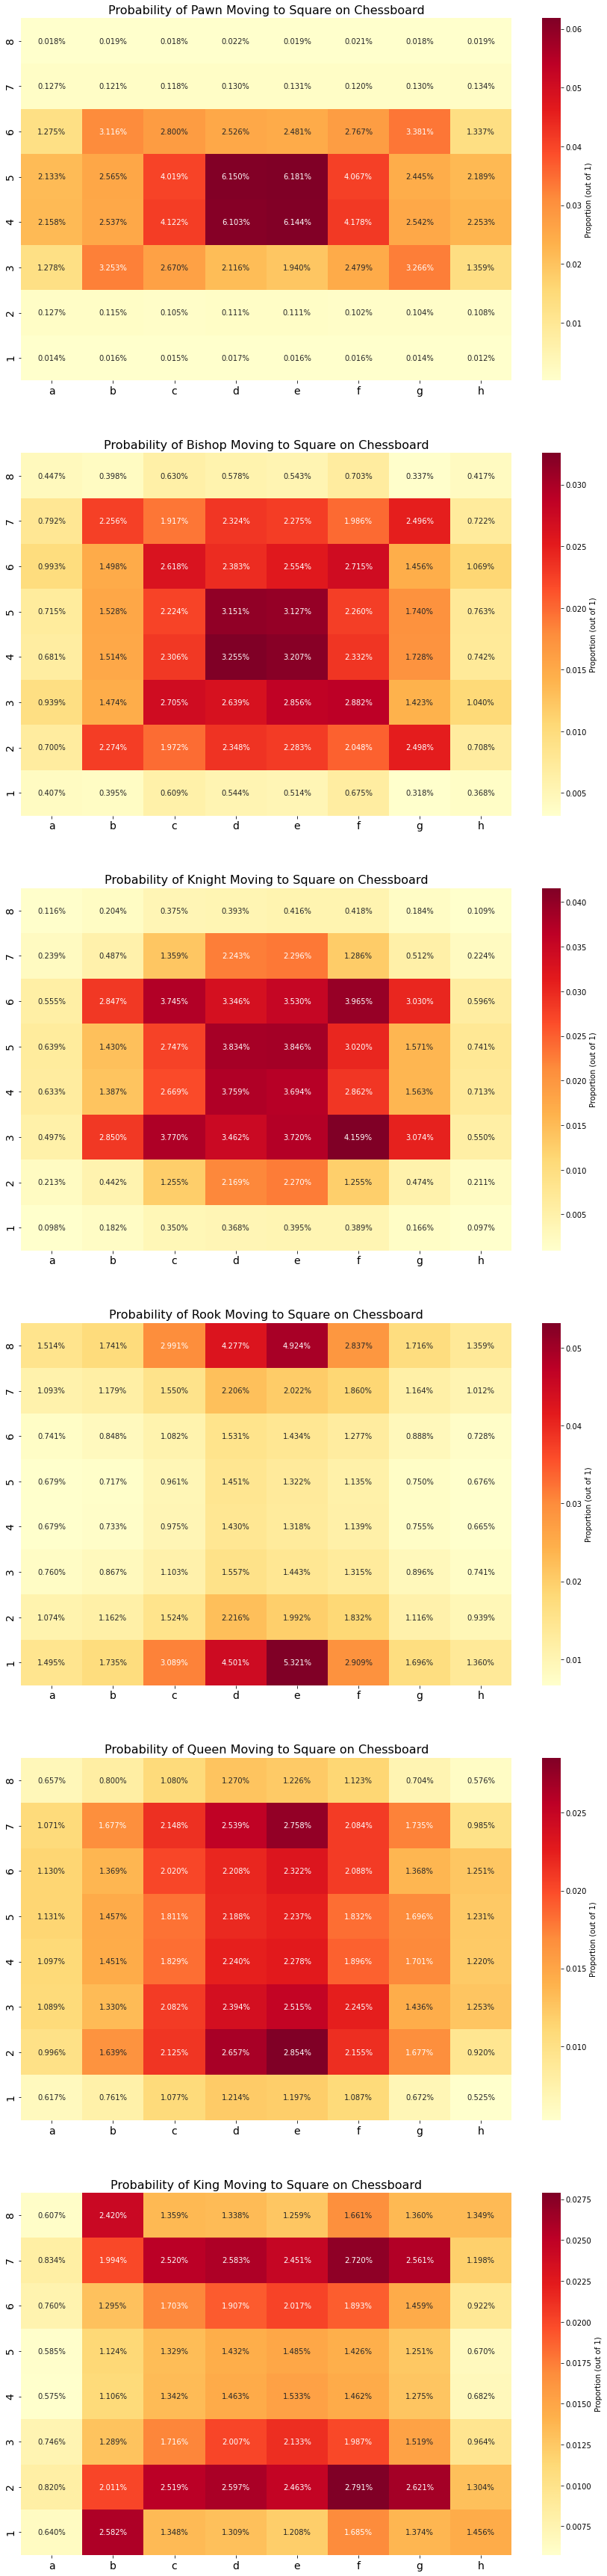

In [112]:
prob_list = []
prob_list.append(prob_dict)
visualize_piece_prob(prob_list)